## Train dataset
了解 client train dataset 的基本情况, 以及一些常用属性和方法

In [1]:
import sys
import os
import random

# 将项目根目录加入到环境变量中
PROJECT_DIR = os.path.dirname(os.getcwd())
print(PROJECT_DIR)
sys.path.append(PROJECT_DIR)

from data.CIFAR10.partition import partition_example

d:\FedLab\MetaCluterFL


In [10]:
# 常规参数
num_client = 50
num_cluster = 10
num_classes = 10

# 数据准备(trainset)
partitioner = partition_example()

data preprocess in Partition is already finished.


                class0  class1  class2  class3  class4  class5  class6   
client2_train      179     215       0       0     203       0     218  \
client2_test       179     215       0       0     203       0     218   
client3_train      201     213       0       0     201       0     182   
client3_test       201     213       0       0     201       0     182   
client6_train        0       0     406     225       0       0       0   
client6_test         0       0     406     225       0       0       0   
client10_train     403       0     189       0       0       0       0   
client10_test      403       0     189       0       0       0       0   
client11_train     399       0     203       0       0       0       0   
client11_test      399       0     203       0       0       0       0   
client12_train     395       0     194       0       0       0       0   
client12_test      395       0     194       0       0       0       0   
client13_train     412       0     194

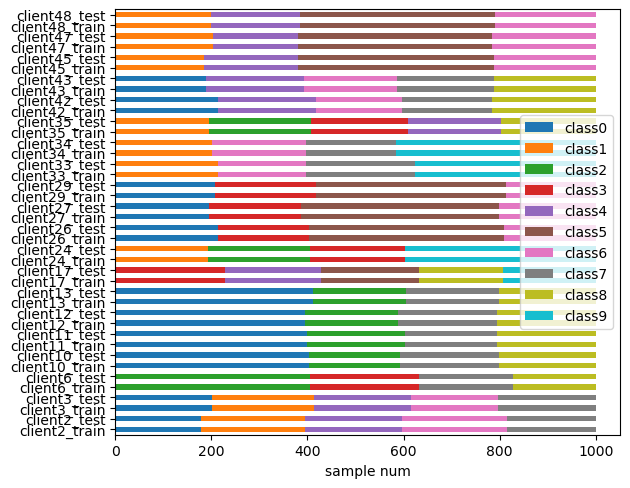

In [11]:
# 绘制 partitioned_dataset 中 client 的数据的 label 分布
partitioner.plot_train_test_label()

In [12]:
# 查看 partitioned_dataset 中 client 的数据
client_id = random.randint(0, num_client - 1)
client_dataset = partitioner.get_dataset(client_id)
print("client_id: {} has {} data".format(client_id, len(client_dataset)))

# 查看 client_dataset 中的数据的 shape
print("client_dataset[0] typs: {}".format(type(client_dataset[0])))
print("client_dataset[0][0] typs: {}".format(type(client_dataset[0][0])))
print("client_dataset[0][1] typs: {}".format(type(client_dataset[0][1])))
print("client_features.shape: {}".format(client_dataset[0][0].shape))

# 统计 client_dataset 中的数据的 label 分布
def statistic_label_distribution(labels):
    label_distribution = [0 for i in range(num_classes)]
    
    for label in labels:
        label_distribution[label] += 1
    
    label_distribution = [num / len(labels) for num in label_distribution]
    
    return label_distribution

client_labels = client_dataset.y
client_labels_distribution = statistic_label_distribution(client_labels)
print("client_labels_distribution: {}".format(client_labels_distribution))

client_id: 1 has 1000 data
client_dataset[0] typs: <class 'tuple'>
client_dataset[0][0] typs: <class 'torch.Tensor'>
client_dataset[0][1] typs: <class 'int'>
client_features.shape: torch.Size([3, 32, 32])
client_labels_distribution: [0.209, 0.179, 0.0, 0.0, 0.207, 0.0, 0.197, 0.208, 0.0, 0.0]


## Test dataset
了解 test dataset 总体数据的基本属性, 以及根据 client 的label 分布分配 client testset

In [13]:
import torchvision

In [14]:
# all test dataset
testset = torchvision.datasets.CIFAR10(root=partitioner.root, train=False, download=False, transform=partitioner.transform)

# 查看 testset 对象中可用的属性
print("testset.targets type: {}".format(type(testset.targets)))
print("testset.data type: {} \n".format(type(testset.data)))

# 查看 testset 对象中的数据的 shape
print("testset.targets len: {}".format(len(testset.targets)))
print("testset.data shape: {}".format(testset.data.shape))

testset.targets type: <class 'list'>
testset.data type: <class 'numpy.ndarray'> 

testset.targets len: 10000
testset.data shape: (10000, 32, 32, 3)


In [15]:
# 统计 testset 中不同 label 的 index
def statistic_label_index(labels):
    label_index = {i:[] for i in range(num_classes)}
    for index, label in enumerate(labels):
        label_index[label].append(index)
    return label_index

test_labels_index = statistic_label_index(testset.targets)
# print("test_labels_index: {}".format(test_labels_index))
for k, v in test_labels_index.items():
    print("label: {} has {} data".format(k, len(v)))

label: 0 has 1000 data
label: 1 has 1000 data
label: 2 has 1000 data
label: 3 has 1000 data
label: 4 has 1000 data
label: 5 has 1000 data
label: 6 has 1000 data
label: 7 has 1000 data
label: 8 has 1000 data
label: 9 has 1000 data


In [16]:
# 根据 client_labels_distribution 从 testset 中抽取数据
def sample_client_test_data(distribution, testset_data, testset_labels):
    sample_indices = []
    for label, rate in enumerate(distribution):
        num = int(rate * len(test_labels_index[label]))
        sample_indices.extend(random.sample(test_labels_index[label], num))
    
    client_sample_test_features = []
    client_sample_test_labels = []
    for idx in sample_indices:
        client_sample_test_features.append(testset_data[idx])
        client_sample_test_labels.append(testset_labels[idx])
    
    return client_sample_test_features, client_sample_test_labels


print("client_labels_distribution: {}".format(client_labels_distribution))
client_sample_test_features, client_sample_test_labels = sample_client_test_data(client_labels_distribution, testset.data, testset.targets)

client_sample_test_labels_distribution = statistic_label_distribution(client_sample_test_labels)
print("client_sample_test_labels_distribution: {}".format(client_sample_test_labels_distribution))

client_labels_distribution: [0.209, 0.179, 0.0, 0.0, 0.207, 0.0, 0.197, 0.208, 0.0, 0.0]
client_sample_test_labels_distribution: [0.209, 0.179, 0.0, 0.0, 0.207, 0.0, 0.197, 0.208, 0.0, 0.0]


## DataLoader 中 data.shape 的变化
从下面的例子中可知：

对于 dataloader 中的数据, 直接通过 index 取得的数据 shape 为 (32, 32, 3)

而对 dataloader 进行遍历, 则其数据 shape 变为 (3, 32, 32)

对于 dataset 中的数据, 无论是直接用 index 取, 还是通过遍历获取, 其数据 shape 都为 (3, 32, 32)

In [17]:
print("testset.data[0] shape: {}".format(testset.data[0].shape))

iter_testset = iter(testset)
data = next(iter_testset)
print("iter_testset.data[0] shape: {}".format(data[0].shape))

for data, label in testset:
    print("forloop testset.data[0] shape: {}".format(data.shape))
    break

print("client_dataset[0][0] shape: {}".format(client_dataset[0][0].shape))
for data, label in client_dataset:
    print("forloop client_dataset[0][0] shape: {}".format(data.shape))
    break

# client_dataloader 是 client_dataset 经过 DataLoader 封装后的对象
client_dataloader = partitioner.get_dataloader(10, batch_size=64)
for data, label in client_dataloader:
    print("client_dataloader data shape: {}".format(data.shape))
    break

testset.data[0] shape: (32, 32, 3)
iter_testset.data[0] shape: torch.Size([3, 32, 32])
forloop testset.data[0] shape: torch.Size([3, 32, 32])
client_dataset[0][0] shape: torch.Size([3, 32, 32])
forloop client_dataset[0][0] shape: torch.Size([3, 32, 32])
client_dataloader data shape: torch.Size([64, 3, 32, 32])


## Dataloader 获取批数据的变化
每次 dataset.get_dataloader, 数据总量不变, 数据的出现顺序发生改变

In [18]:
def get_data_batch(dataset, client_id, batch_size):
    dataloader = dataset.get_dataloader(client_id, batch_size)
    iter_dataloader = iter(dataloader)
    try:
        x,y = next(iter_dataloader)
    except StopIteration:
        iter_dataloader = iter(dataloader)
        x,y = next(iter_dataloader)
    return x,y

In [19]:
data_batch_1 = get_data_batch(partitioner, 1, 64)
print(data_batch_1[0][0][0][0])

data_batch_2 = get_data_batch(partitioner, 1, 64)
print(data_batch_2[0][0][0][0])

tensor([-0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.1059,
        -0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.1059,
        -0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.1059,
        -0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.1059, -0.0902])
tensor([ 1.0000,  0.9608,  0.9373,  0.9451,  0.9765,  0.7255,  0.1373, -0.2000,
        -0.1843,  0.4745,  0.9843,  0.9843,  0.9843,  0.9843,  0.9843,  0.9843,
         0.9843,  0.9843,  0.9843,  0.9843,  0.9843,  0.9843,  0.9843,  0.9843,
         0.9843,  0.9843,  0.9843,  0.9843,  0.9843,  0.9843,  0.9765,  1.0000])


In [20]:
# 数据总量不变
client_dataload = partitioner.get_dataloader(1, 64)
client_data_total = 0
for data, label in client_dataload:
    client_data_total += len(data)
print("client_data_total: {}".format(client_data_total))

client_data_total: 1000
